In [1]:
pip install pandas scikit-learn matplotlib seaborn nltk


Note: you may need to restart the kernel to use updated packages.



--- Classification Report ---
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4311
           1       0.99      0.98      0.98      4669

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980


Accuracy: 0.9829


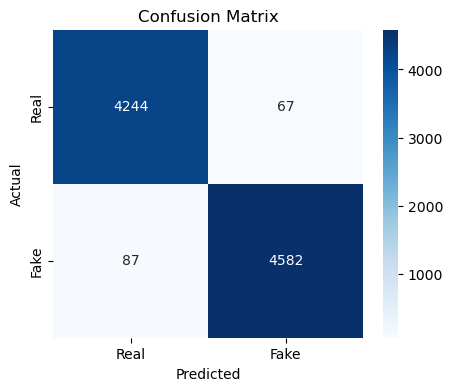


Prediction: REAL
Bayesian Explanation (Posterior Probabilities):
P(Real | Article) = 0.9357
P(Fake | Article) = 0.0643


In [2]:
# --- 1. Import Required Libraries ---
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.calibration import CalibratedClassifierCV

# --- 2. Load and Label Data ---
true_df = pd.read_csv('true.csv')
fake_df = pd.read_csv('fake.csv')

true_df['label'] = 0  # Real
fake_df['label'] = 1  # Fake

df = pd.concat([true_df, fake_df], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# --- 3. Text Cleaning Function ---
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['text'].apply(clean_text)

# --- 4. Feature Extraction (TF-IDF) ---
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X = vectorizer.fit_transform(df['text'])
y = df['label']

# --- 5. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 6. Train Logistic Regression with Probability Calibration ---
lr_model = LogisticRegression(max_iter=1000)
calibrated_model = CalibratedClassifierCV(lr_model, cv=5)
calibrated_model.fit(X_train, y_train)

# --- 7. Evaluation ---
y_pred = calibrated_model.predict(X_test)
y_proba = calibrated_model.predict_proba(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))
print("\nAccuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# --- 8. Predict and Explain with Bayes Theorem ---
def explain_with_bayes(text):
    cleaned = clean_text(text)
    vec = vectorizer.transform([cleaned])
    pred = calibrated_model.predict(vec)[0]
    proba = calibrated_model.predict_proba(vec)[0]

    label = "FAKE" if pred == 1 else "REAL"
    print(f"\nPrediction: {label}")
    print("Bayesian Explanation (Posterior Probabilities):")
    print(f"P(Real | Article) = {proba[0]:.4f}")
    print(f"P(Fake | Article) = {proba[1]:.4f}")

# --- 9. Example ---
sample_news = "The government has announced new healthcare policies starting next year."
explain_with_bayes(sample_news)


In [16]:
import joblib

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')


# Save the trained calibrated logistic regression model
joblib.dump(calibrated_model, 'calibrated_lr_model.joblib')


['calibrated_lr_model.joblib']

In [10]:
import os
print(os.getcwd())


C:\Users\NAC


In [18]:
joblib.dump(vectorizer, 'tfidf_vectorizer.joblib')


['tfidf_vectorizer.joblib']